# Introduction to Python for Earth Scientists

These notebooks have been developed by Calum Chamberlain, Finnigan Illsley-Kemp, John Townend and El Mestel at [Victoria University of Wellington-Te Herenga Waka](https://www.wgtn.ac.nz) for use by Earth Science graduate students. 

The notebooks cover material that we think will be of particular benefit to those students with little or no previous experience of computer-based data analysis. We presume very little background in command-line or code-based computing, and have compiled this material with an emphasis on general tasks that a grad student might encounter on a daily basis. 

In 2024, this material will be delivered at the start of Trimester 1 in conjunction with [ESCI451 Active Earth](https://www.wgtn.ac.nz/courses/esci/451). Space permitting, interested students not enrolled in ESCI451 are encouraged to come along too but please contact El, Calum, Finn, or John first.

| Notebook | Contents | Data |
| --- | --- | --- |
| [1A](ESCI451_Module_1A.ipynb) | Introduction to programming, Python, and Jupyter notebooks | - |
| [1B](ESCI451_Module_1B.ipynb) | Basic data types and variables, getting data, and plotting with Matplotlib | Geodetic positions |
| **[2A](ESCI451_Module_2A.ipynb)** | **Logic, more complex plotting, introduction to Numpy** | **Geodetic positions; DFDP-2B temperatures** |
| [2B](ESCI451_Module_2B.ipynb) | Using Pandas to load, peruse and plot data | Earthquake catalogue  |
| [3A](ESCI451_Module_3A.ipynb) | Working with Pandas dataframes | Geochemical data set; GNSS data |
| [3B](ESCI451_Module_3B.ipynb) | Simple time series analysis using Pandas | Historical temperature records |
| [4A](ESCI451_Module_4A.ipynb) | Making maps with PyGMT | Earthquake catalogue |
| [4B](ESCI451_Module_4B.ipynb) | Gridded data and vectors | Ashfall data and GNSS |
| [Scripting](ESCI451_Module_5A_Scripting.ipynb) | Moving from notebooks to scripts and the command line | - |

The content may change in response to students' questions or current events. Each of the four modules has been designed to take about three hours, with a short break between each of the two parts.

# This notebook

1. Logic
   - Looping
   - Functions
   - Classes
2. More plotting using Matplotlib
   - Customising plots
   - Using style sheets
   - Plotting uncertainties
3. An introduction to NumPy
   - Speed
   - Reading data from a text file into a NumPy array
   - Indexing and slicing NumPy arrays
   - Doing maths with an array
   - Saving data to a text file

# Logic

<img alt="xkcd 1319 automation
              'I spend a lot of time on this task. I should write a program automating it!'
    [Two graphs are shown, plotting workload against time.]
    Theory:
    [The line for 'work on original task' is steady but then drops down to a much lower level.]
    [The line for the automating job increases heavily while 'writing code' and then drops down when 'automation takes over'.]
    [Both lines end up with a big amount of 'free time'.]
    Reality:
    [The line for 'work on original task' is steady with no drop to a lower level.]
    [The line for the automating job increases heavily while 'writing code', then it increases again while 'debugging', it drops down slightly while 'rethinking', and grows up again with an infinite end while the task is still an 'ongoing development'.]
    [The line for 'work on original task' ends up with 'no time for original task anymore'.]
          " align="right" style="width:40%" src="https://imgs.xkcd.com/comics/automation.png">

One of the main goals of programming is to automate things. The main reasons for this are:

1. **Doing dull things manually is boring**: You, a highly trained scientist, should be doing something more worthwhile than moving decimal points in spreadsheets;
2. **Reproducibility**: someone should be able to take what you have done and re-do it, without your "fudging". The more your "expert opinion" is used to generate a result, the less trust-worthy that result is.
3. **Safety**: you will cock something up (likely many things, that is what learning is about) while doing your science; if you write a program to do the thing, and write it well, you should just have to make minor adjustments to fix the issue and re-run it, rather than having to re-do all the boring work (see 1).
   
Sometimes automation takes ages... you will learn at some point (or not in my case) what the most efficient use of your time is (see comic).

To be able to automate things, you need to understand some basic computer logic.  These concepts are pretty much universal.  In this notebook we will introduce:

1. For loops
2. If/else statements
3. While loops
4. Sorting lists

We will also showcase some niceties/nuances that Python has for these.

## Looping

There are two main ways to loop in Python, `for` loops and `while` loops.  You will likely find yourself using
`for` loops more often than `while` loops, but we will introduce both. the main difference is that `for` loops
iterate through a range of variables, whereas `while` loops operate repeatedly until some condition is met.
We will talk about conditions in the `if`/`else` section, before getting onto `while` loops.

The following two loops are equivalent, but the `for` loop is more expressive and usually safer (`while` loops
are the cause of many infinite loops...):

In [1]:
for i in range(5):
    print(i)

0
1
2
3
4


In [2]:
i = 0
while i < 5:
    print(i)
    i += 1

0
1
2
3
4


## `for` loops

`for` loops allow us to iterate through some *iterable*. Often this *iterable* is a `list`, but it doesn't have to be (the `range` function above creates a `range` object, which is a type of [sequence](https://docs.python.org/3/library/stdtypes.html#typesseq)).

If we have any `list` and we want to apply the same process to every element in that list, we can use a `for` loop (there are better/faster ways to do this for numeric types using **numpy**, and we will showcase those in below).

In Python, `for` loops start with:
```python
for variable in iterable:
    do_something
```
where `variable` is a newly defined variable that equates to each element of the `iterable` in turn. At the end of the loop `variable` will be the value of `iterable[-1]`. `iterable` is something that can be iterated over.  The `for` and `in` are Python *keywords* that Python knows how to interpret. The colon (`:`) at the end of the `for` line shows that that statement has finished.

All the statements that should be implemented within the loop **must** be indented, this indentation *should* be 4 spaces (not a tab).  

**Never mix tabs and spaces!**  

When the indentation ends, the loop ends.

For example, say we wanted to make a list of word lengths for a given sentence:

In [3]:
sentence = "Monty Python and the Holy Grail"
words = sentence.split(" ")

word_lengths = []  # Define an empty list that we will append to
for word in words:
    word_length = len(word)
    print(f"{word} is {word_length} letters long")
    word_lengths.append(word_length)

print(word_lengths)

Monty is 5 letters long
Python is 6 letters long
and is 3 letters long
the is 3 letters long
Holy is 4 letters long
Grail is 5 letters long
[5, 6, 3, 3, 4, 5]


## `if`/`else` conditions

Switches or conditional statements allow a programmer to control the flow of a program, and react to events.

The basic syntax of conditional statements in Python is:

```python
if condition:
    do_something()
elif another_condition:
    do_something_else()
else:
    do_anything()
```

As usual, indentation is used to show the start and end of sections of code, and colons are used to show the
end of a statement.  The three keywords here, `if`, `elif` and `else` do the following:
- `if` evaluates whether `condition` is `True`, and runs the section of code indented beneath it (`do_something()`) if `condition` is `True`;
- `elif` is evaluated if `condition` is `False`. This is a second `if` conditional that evaluates whether `another_condition` is `True`. The function `do_something_else` is only run if `condition` is `False` and `another_condition` is `True`.
- `else` catches any cases where the previous `if` statements evaluated to False. `do_anything` is run when both `condition` and `another_condition` are `False`.
  
This is a little confusing to write, so it probably doesn't make much sense to read! Lets have a look at an example.  First note that mathematical conditions work in Python:
- `a == b` is `True` when the values of `a` and `b` are the same
- `a != b` is `True` when the values of `a` and `b` are **not** the same
- `a < b` is `True` when the value of `a` is less than the value of `b`
- ... The expected things happen for `>`, `>=` and `<=`. These symbols are known as *comparison operators* in Python.


In [4]:
a = 5

# This is a pretty dumb example! But we will do some more fun things in a minute
if a < 5:
    print("That is a small number, less than 5")
elif a > 5:
    print("That is a larger number, greater than 5")
else:
    print("Your number must be equal to 5!")

Your number must be equal to 5!


What if you want to check multiple conditions?! You could write something like:

In [5]:
a = 3
if a < 5:
    if a >= 2:
        print("Your number is between two and five!")

Your number is between two and five!


But that is a bit excessive - you just want to know if a is less than five `and` greater than or equal to 2!

Python is nice and uses keywords, so this is as simple as:

In [6]:
if a < 5 and a >= 2:
    print("Bonza!")

Bonza!


As well as the `and` conditional keyword there are others:
- `or` for checking whether one of multiple conditions is met;
- `in` for testing if something is within another object, useful for checking if something is in a `list`;
- `is` tests whether something is the same as another thing, rather than just testing the value;
- `not` reverses any test.

Some examples:

In [7]:
a = 1
b = 3
c = 42

# Example of an or conditional
a > b or a > c

False

In [8]:
a > b or a < c

True

In [9]:
a > b and a < c

False

In [10]:
a < b and a < c

True

In [11]:
a < b and not a > c

True

In [12]:
d = [1, 4, 12]

a in d

True

In [13]:
c in d

False

*Note* that the operators `=` and `==` are not the same. Be careful not to mix them up!
 - `=` is used for definiton. `a = 5` means we are defining the variable `a` to have the value `5`.
  - `==` is used for comparison. `a == 5` checks if the variable `a` is equal to `5` and will return the value `True` if it is. 

In [5]:
a = 5
b = 5

a == b

True

In [6]:
a = 5
b = 4

a == b

False

In [7]:
a = 5
b = 4

a != b

True

## `while` loops:

While loops are helpful for iterating through some list until you reach some state, for example, if you want to find the first
instance of something in a list:

In [14]:
sentence = "The cat sat on the mat then jumped across the dog"
words = sentence.split(" ")
print(words)

i = 0
word = words[i]
while not word == "mat":
    i += 1
    word = words[i]
print(f"Found {word} at index {i}")

['The', 'cat', 'sat', 'on', 'the', 'mat', 'then', 'jumped', 'across', 'the', 'dog']
Found mat at index 5


Use `while` loops with caution! If the condition is never `False`, then you will end up in an infinite loop! Ahhh!

For example, the following code will never complete:
```python
i = 0
while i >= 0:
    print(i)
    i += 1
```

# Functions and classes

<img alt="xkcd 1205 Is it worth the time?
              [Above the frame is written the following text:]
    How long can you work on making a routine task more efficient before you're spending more time than you save? 
    (across five years)
    [The rest of the comic is given in a tabular format. At the top of the table is how often you do the task, with six time increments underneath, and then at the side is written How much time do you shave off at the leftmost part of the page, with 9 lengths of time to the left. The empty fields in the calendar are shaded dark gray.]
    [The first row is for 1 second, where the table values are 1 day (for 50 per day), 2 hours (for 5 per day), 30 minutes (for daily), 4 minutes (for weekly), 1 minute (for monthly), and 5 seconds (for yearly).]
    [The second row is for 5 seconds, where the table values are 5 days (for 50 per day), 12 hours (for 5 per day), 2 hours (for daily), 21 minutes (for weekly), 5 minutes (for monthly), and 25 seconds (for yearly).]
    [The third row is for 30 seconds, where the table values are 4 weeks (for 50 per day), 3 days (for 5 per day), 12 hours (for daily), 2 hours (for weekly), 30 minutes (for monthly), and 2 minutes (for yearly).]
    [The fourth row is for 1 minute, where the table values are 8 weeks (for 50 per day), 6 days (for 5 per day), 1 day (for daily), 4 hours (for weekly), 1 hour (for monthly), and 5 minutes (for yearly).]
    [The fifth row is for 5 minutes, where the table values are 9 months (for 50 per day), 4 weeks (for 5 per day), 6 days (for daily), 21 hours (for weekly), 5 hours (for monthly), and 25 minutes (for yearly).]
    [The sixth row is for 30 minutes, where the table values are greyed out (for 50 per day), 6 months (for 5 per day), 5 weeks (for daily), 5 days (for weekly), 1 day (for monthly), and 2 hours (for yearly).]
    [The seventh row is for 1 hour, where the table values are greyed out (for 50 per day), 10 months (for 5 per day), 2 months (for daily), 10 days (for weekly), 2 days (for monthly), and 5 hours (for yearly).]
    [The eighth row is for 6 hours, where the table values are greyed out (for 50 per day, 5 per day and daily), 2 months (for weekly), 2 weeks (for monthly), and 1 day (for yearly).]
    [The ninth and final row is for 1 day, where the table values are greyed out (for 50 per day, 5 per day, daily and weekly), 8 weeks (for monthly), and 5 days (for yearly).]
          " align="right" style="width:40%" src=https://imgs.xkcd.com/comics/is_it_worth_the_time.png>

A wise geophysics technician once told me that the point of functions and classes is to write the language you wish you had. Ideally you could have code that looks like:

```python
data = read_some_data()
processed_data = do_the_mahi(data)
paper_draft = make_manuscript(processed_data)
nobel_prize = submit_and_review(paper_draft)
```

It doesn't quite work like that, but functions are there to make your life easier! The main reason they make your life easier boils down to the programming principle of [DRY (Don't Repeat Yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself).


In general you should solve a problem once, solve it well and reuse that solution. Duplication is waste, and solving a problem again introduces more sources of error.  Better still, if someone has solved your problem for you, don't solve it again (unless you think they are wrong). 

If you do have to solve the problem yourself, you should solve the problem first, and optimise later. A fast but incorrect solution is still wrong (and this is why **tests are important**).

## Functions in Python

Functions allow you to write some code with specified inputs do some work, and get a returned value (or not if you don't want to, remember, we can work in-place on variables). 

Lets say we want to work out the length of the third side of a right-angled triangle, we could (and should) write a function to do this.  In Python functions are declared with the following syntax:

```python
def function_name(argument_1, argument_2):
    """ 
    This function does something. 
    
    Parameters
    ----------
    argument_1
        Some argument
    argument_2
        Another argument
        
    Returns
    -------
    Some value
    """
    output = do_something(argument_1, argument_2)
    return output
```
where `function_name` is a user-defined name for the function, `argument_1` and `argument_2` are values passed to the function and used by the function, `return` is a keyword argument showing that the function is ending and returning the value stored in `output`.  Note again that indentation is important, and that the `def ...` statement must end with a colon (`:`).

The names for arguments do not need to be the same as the variables in the rest of your script, those variable names are only active within the scope of the function.  As with variable naming, functions should be named usefully, and their names should not be the same as any other function of variable.

The text within the three quotes (`""" text """`) serves to document the purpose of the function, what the arguments are, and what is returned.  It is good practice to document all functions so that you can easily understand what they are doing!

The function below is our attempt at computing the length of the third side of a right-angled triangle:

In [2]:
def hypotenuse(a, b):
    """
    Compute the length of the hypotenuse of a right-angled triangle given two sides

    Parameters
    ----------
    a
        The length of one side
    b
        The length of the other side

    Returns
    -------
    The length of the hypotenuse
    """
    c = (a ** 2 + b ** 2) ** 0.5
    return c

In [16]:
hypotenuse(a=3, b=4)  # A simple pythagorean triple, useful little test-case!

5.0

**Exercise:**

Write a function to calculate the mean of a list of values.

In [17]:
# Your code here.

Now that you have a function, you can reuse it (yay!). This is one of the main ideas behind DRY (Don't Repeat Yourself, and yes, I am aware of the irony in repeating myself here...). One simple way to reuse a function is to call it multiple times in a loop. 

As a simple example, say we wanted to compute the hypotenuse of a series of triangles - we can use our function from before within a loop:

In [3]:
a_list = [2, 5, 3, 6]
b = 10

for a in a_list:
    hyp = hypotenuse(a, b)
    print(f"Triangle {a}, {b} has hypotenuse {hyp}")

Triangle 2, 10 has hypotenuse 10.198039027185569
Triangle 5, 10 has hypotenuse 11.180339887498949
Triangle 3, 10 has hypotenuse 10.44030650891055
Triangle 6, 10 has hypotenuse 11.661903789690601


## Classes

---

***Caution:*** You don't need to understand the details of classes! BUT you will interact with them a lot. You can skim over the next section, but it is here for reference/interest if you want it!

---

I want to introduce you to classes here, but you probably won't write any for a while. You will interact with many though (everything in python is an object...) which is the main reason I want to show you them!

Python is an [object-oriented](https://en.wikipedia.org/wiki/Object-oriented_programming) language.  Objects are things that can contain data (properties) alongside functions (methods) that operate on them. Everything in Python is an object, but some are less obvious than others.  Methods on objects are accessed using the following syntax:

```python
obj.method(arguments, ...)
```

Properties are accessed without the brackets, e.g.:

```python
obj.property
```

We have already seen the `.append` method on lists, similar attributes can be accessed in this way.

In Python classes are declared using the following syntax:

```python
class ClassName():
    """ 
    Some class.
    
    Parameters
    ----------
    arg_1
        First value
    arg_2
        Second value    
    """
    default_property = 42
    
    def __init__(self, arg_1, arg_2):
        self.arg_1 = arg_1
        self.arg_2 = arg_2
        
    def some_method(self, arg_3):
        """
        Do something with the object and another argument.
        
        Parameters
        ----------
        arg_3
            Some argument
            
        Returns
        -------
        Some output
        """
        output = do_something(
            self.arg_1, self.arg_2, self.default_property, arg_3)
        return output
```

Lets make a class to hold an observation of strike and dip of a plane.  We should keep track of where the observation was made as well, so we will give it `latitude`, `longitude` and `elevation` attributes.

In the class below we have added a *special* method called `__repr__` - this method is used by the the Python interpreter (the thing that converts your Python code into something the computer can actually understand) to work out how to format the string that comes from a `print` call. Generally methods that are of the form: `__method__` with double underscores are protected methods (also reffered to as "dunder" methods as a concatenation of "double underscore") that you don't call directly (e.g. you wouldn't usually run `obj.__repr__()`, you would just run `print(obj)`).

Below is that simple class:

In [5]:
class StrikeDipObservation():
    """
    Holder for Strike and Dip observations.

    Parameters
    ----------
    strike
        Strike of plane in degrees from north
    dip
        Dip of plane in degrees from horizontal, positive down
    latitude
        Latitude of observation in degrees
    longitude
        Longitude of observation in degrees
    elevation
        Elevation of observation in meters above sea level.
    """

    def __init__(self, strike, dip, latitude, longitude, elevation):
        self.strike = strike
        self.dip = dip
        self.latitude = latitude
        self.longitude = longitude
        self.elevation = elevation

    def __repr__(self):
        # This will make a nicely formatted print-string of out class
        return (
            f"StrikeDipObservation(strike={self.strike}, dip={self.dip}, "
            f"latitude={self.latitude}, longitude={self.longitude}, "
            f"elevation={self.elevation})")

In [6]:
plane_observation = StrikeDipObservation(0, 20, -42.0, 172.3, 1203)
print(plane_observation)

StrikeDipObservation(strike=0, dip=20, latitude=-42.0, longitude=172.3, elevation=1203)


This is a nice, but pretty useless class.  Lets add some methods to get the plunge and trend of the pole to the plane, and the unit-vector that describes this pole:

In [8]:
# Class copied from above with extra methods!

# We need to use some sine and cosine functions, which we can get
# from Python's math package.
import math


class StrikeDipObservation():
    """
    Holder for Strike and Dip observations.

    Parameters
    ----------
    strike
        Strike of plane in degrees from north
    dip
        Dip of plane in degrees from horizontal, positive down
    latitude
        Latitude of observation in degrees
    longitude
        Longitude of observation in degrees
    elevation
        Elevation of observation in meters above sea level.
    """

    def __init__(self, strike, dip, latitude, longitude, elevation):
        self.strike = strike
        self.dip = dip
        self.latitude = latitude
        self.longitude = longitude
        self.elevation = elevation

    def __repr__(self):
        # This will make a nicely formatted print-string of out class
        return (
            f"StrikeDipObservation(strike={self.strike}, dip={self.dip}, "
            f"latitude={self.latitude}, longitude={self.longitude}, "
            f"elevation={self.elevation})")

    def plunge(self):
        """ Get the plunge of the pole to the plane. """
        return 90.0 - self.dip

    def trend(self):
        """ Get the trend of the pole to the plane. """
        trend = self.strike - 90.0
        # Ensure positive strike
        if trend > 0:
            return trend
        return self.strike + 270.0

    def unit_vector(self):
        x = (math.sin(math.radians(self.trend())) *
             math.cos(math.radians(self.plunge())))
        y = (math.cos(math.radians(self.trend())) *
             math.cos(math.radians(self.plunge())))
        z = -1 * math.sin(math.radians(self.plunge()))
        # Quick check
        assert 1 - (math.sqrt(x ** 2 + y ** 2 + z ** 2)) < 0.0000001
        return x, y, z

In [9]:
plane_observation = StrikeDipObservation(0, 20, -42.0, 172.3, 1203)
print(plane_observation)

StrikeDipObservation(strike=0, dip=20, latitude=-42.0, longitude=172.3, elevation=1203)


In [10]:
plane_observation.plunge()

70.0

In [11]:
plane_observation.trend()

270.0

In [12]:
plane_observation.unit_vector()

(-0.3420201433256688, -6.282808106515489e-17, -0.9396926207859083)

How very logical...

<img alt="Logical Spok" align="right" style="width:20%" src=https://i.imgflip.com/1eqdbk.jpg>

You will encounter a range of objects if you continue to use Python, so it is important to understand the basic concept that an object can hold both *attributes* (in our case the values of strike, dip, latitude, longitude and elevation), as well as *methods* (in our case the plunge, trend and unit_vector methods). You probably won't have to write your own methods for a while, but they can be very useful for various things, not-least in explicitly allowing some actions to your data.

That is it for now on functions and classes - we will write a few functions in the next few notebooks and we will interact with lots of classes (whether explicitly or implicitly). For now it is important that you know they exist, but I always find it easier to learn with some examples.

And with that, lets get into some plotting!

---

# Some more plotting

In the last notebook we looked at plotting a single data set and labelling the diagram in a helpful way. Next we'll look at how we can combine different data sets (here the three components of motion measured at PYGR) in a single set of axes.

Remember, we first have to import any packages (notably Matplotlib in this case) that we are going to use. We also need to respecify the function we used previously to get the GNSS data from [GeoNet](https://www.geonet.org.nz).

Now is also a good time to explain another line of code you may have seen: `%matplotlib notebook`: this is simply a convenient way of telling Jupyter to display Matplotlib figures in an interactive way, so that they can be zoomed in on etc. Without that line, the Matplotlib output is (was? Jupyter has been updated and it depends on what version you have!) a static figure. Generally you should put that line near the top of your notebook if you want to use it.

In [10]:
%matplotlib widget

import matplotlib.pyplot as plt
import requests  # This helps with web-requests
import datetime  # Python's representation of dates and times.


# The following block of code defines a function that we can use
# as often as we like to get GNSS data for a particular station
def get_gnss_for_station(
        station: str,
        fits_url: str = "http://fits.geonet.org.nz/observation",) -> dict:
    """
    Get GNSS data from GeoNet for the station

    Parameters
    ----------
    station
        The name of the station you want to get data for
    fits_url
        URL of the FITS data service you want to query.

    Returns
    -------
    Dictionary with keys:
        time 
            list of timestamps of observations
        north
            list of offsets in mm in the north direction
        east
            list of offsets in mm in the east direction
        up          
            list of vertical offsets in mm
        north_error
            list of errors in mm for north
        east_error
            list of errors in mm for east
        up_error
            list of erros in mm for up

    """
    # Initialise an empty dictionary that we will append to
    out = dict(time=[],
               north=[],
               east=[],
               up=[],
               north_error=[],
               east_error=[],
               up_error=[])
    for channel in {"north", "east", "up"}:
        parameters = {"typeID": channel[0], "siteID": station}
        response = requests.get(fits_url, params=parameters)
        assert response.status_code == 200, "Bad request"
        payload = response.content.decode("utf-8").split("\n")
        # payload is a csv with header
        # This is a list-comprehension, a type of fast, one-line for loop
        payload = [p.split(',') for p in payload]
        # Check that this is what we expect
        assert payload[0][0] == 'date-time', "Unkown format"
        assert len(payload[0]) == 3, "Unknown format"
        times, displacements, errors = zip(*[
            (datetime.datetime.strptime(p[0], '%Y-%m-%dT%H:%M:%S.%fZ'),
             float(p[1]), float(p[2])) for p in payload[1:-1]])
        if len(out["time"]) == 0:
            out.update({"time": times})
        else:
            assert out["time"] == times, "Different time sampling for different components."
        out.update({channel: displacements, f"{channel}_error": errors})
    return out

Next we'll do something similar to the last exercise but use a `loop` to avoid writing the same code three times.

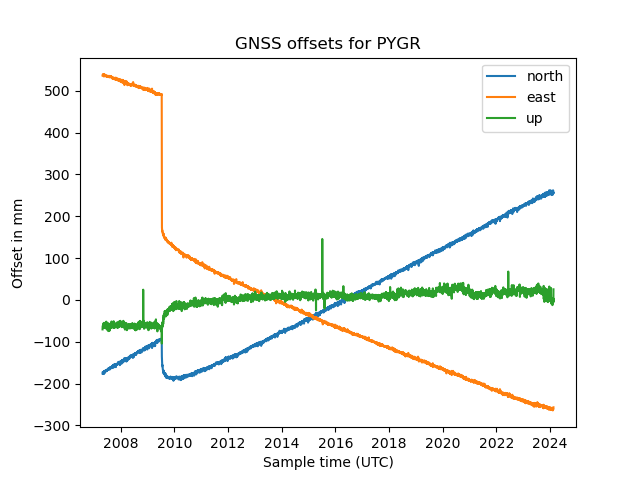

In [11]:
pygr_data = get_gnss_for_station(station="PYGR")
fig, ax = plt.subplots()
# This is the loop
for component in ["north", "east", "up"]:
    ax.plot(pygr_data["time"], pygr_data[component],
            label=component)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

The step shows up on all components! Who would have thought it...?

## Customizing plots

Matplotlib automatically plots each line in a different colour, which is great! But maybe you don't like the
default colours? We can specify colours, and loop through them as well if we want:

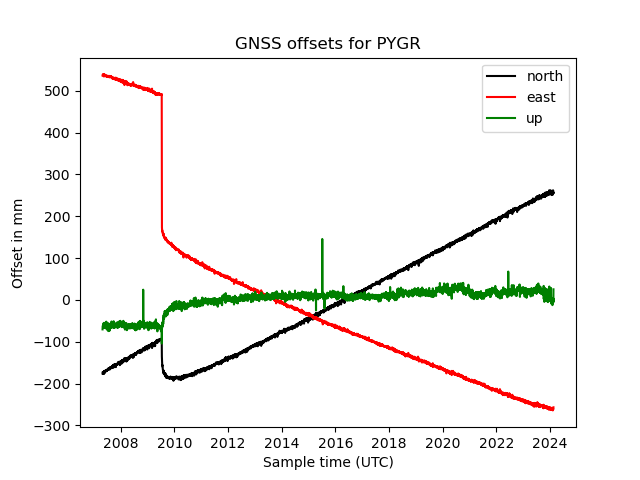

In [12]:
fig, ax = plt.subplots()
# Using the `zip` command we can iterate through pairs of lists.
for component, colour in zip(["north", "east", "up"], ["black", "red", "green"]):
    # We add the color keyword argumet to set the colour of the line.
    ax.plot(pygr_data["time"], pygr_data[component],
            label=component, color=colour)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

You will note that Matplotlib uses American spelling. This is the case with pretty much all aspects of the Python world, and you'll just have to get used to it. (Of course, you're free to use whatever spelling conventions you like when naming variables, as long as you adhere to the general guidelines we've mentioned previously...)

## Using style sheets
You can control all sorts of other style aspects of Matplotlib. One of the simplest ways is to change the `stylesheet` that matplotlib is using.  There are quite a few of them, with  [examples here](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html). Try experimenting with different options to see which ones you prefer. It's worth bearing in mind that some people might not be able to see the differences between colours. 

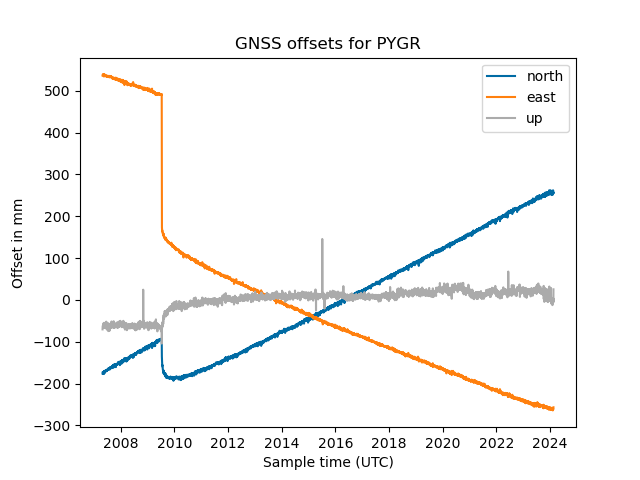

In [13]:
plt.style.use("tableau-colorblind10")
fig, ax = plt.subplots()
for component in ["north", "east", "up"]:
    ax.plot(pygr_data["time"], pygr_data[component],
            label=component)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

Nice.

Something you might find yourself wanting to do now and again is to focus on only part of your data. One way of doing that is to just change the limits of the axes:

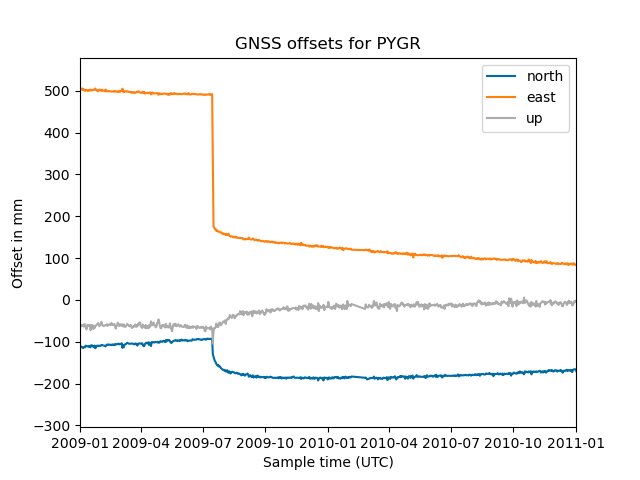

In [14]:
fig, ax = plt.subplots()
for component in ["north", "east", "up"]:
    ax.plot(pygr_data["time"], pygr_data[component],
            label=component)
ax.set_xlim(datetime.datetime(2009, 1, 1), datetime.datetime(2011, 1, 1))
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

We will look at some other methods in the next notebook when we encounter the infamous `Pandas` dataframe...

So far we have plotted data as a continuous line.  For continuous data like this, this is fine, but what if we want
to look at discrete samples?

In matplotlib you can make a scatter plot by specifying a marker (in this case we are using a **o** symbol, which gives a circle),
and setting the `linestyle` to `"None"` (or perhaps `dotted` or even `dashed`, if you want to retain a bit of a line). You can achieve the same result using `ax.scatter(x, y, marker="o")`,
but we will use the `.plot` method here because we need the arguments later...

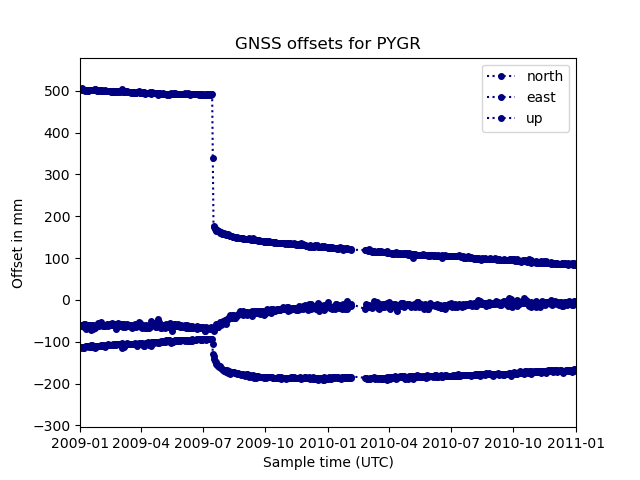

In [15]:
fig, ax = plt.subplots()
for component in ["north", "east", "up"]:
    ax.plot(pygr_data["time"], pygr_data[component],
            marker="o", markersize=4, linestyle="dotted", color='navy',
            label=component)
ax.set_xlim(datetime.datetime(2009, 1, 1), datetime.datetime(2011, 1, 1))
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

We can immediately see that there is a gap in the data in early 2010 that wasn't obvious in our previous plots, which is helpful reminder that "continuous" data are not always as continuous as they seem.

## Plotting uncertainties

The data that we are plotting are daily solutions of position relative to some reference point.  These daily solutions are
essentially averages (with quite a lot of extra noise reduction and weighting) of samples taken at much higher frequencies.
These positions are provided with error estimations: you should always plot your uncertainty to ensure you are not
over-interpreting features.  Lets plot some error bars on these points.

Remember those `marker` and `linestyle` arguments? We need them here as well.

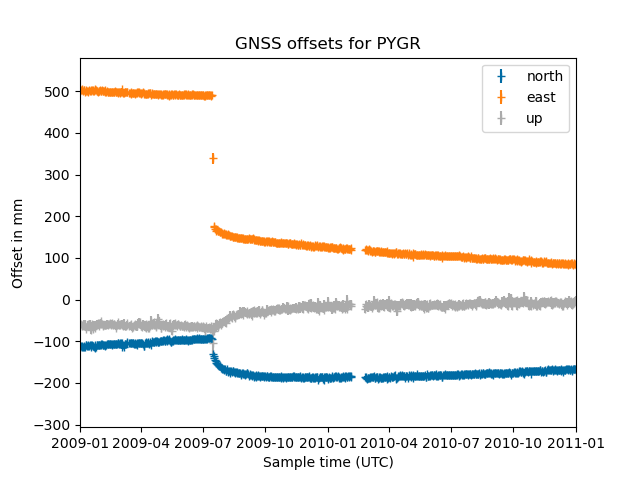

In [16]:
fig, ax = plt.subplots()
for component in ["north", "east", "up"]:
    ax.errorbar(pygr_data["time"], pygr_data[component],
                yerr=pygr_data[f"{component}_error"],
                marker="+", linestyle="None",
                label=component)
ax.set_xlim(datetime.datetime(2009, 1, 1), datetime.datetime(2011, 1, 1))
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

They are plotted, but hard to see, lets plot just the vertical (up) component between 2009/06 and 2009/08:

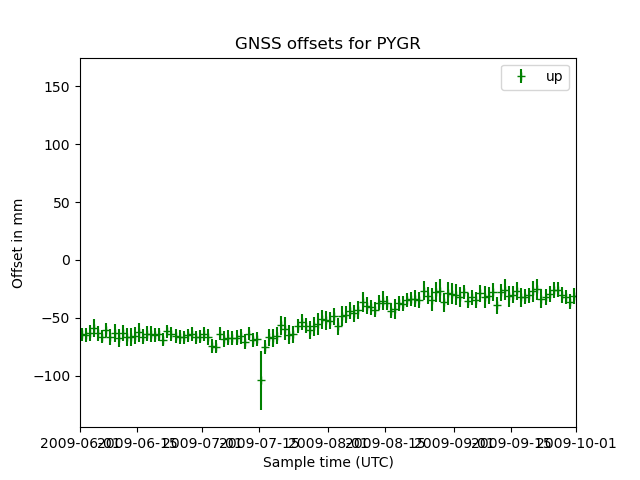

In [17]:
fig, ax = plt.subplots()
ax.errorbar(pygr_data["time"], pygr_data["up"],
            yerr=pygr_data["up_error"],
            marker="+", linestyle="None",
            label=component, color="green")
ax.set_xlim(datetime.datetime(2009, 6, 1), datetime.datetime(2009, 10, 1))
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

This has kept the y-limits the same as for the whole dataset, meaning that we still can't see much! Let's adjust those
y limits in the same way that we adjusted the x-limits.

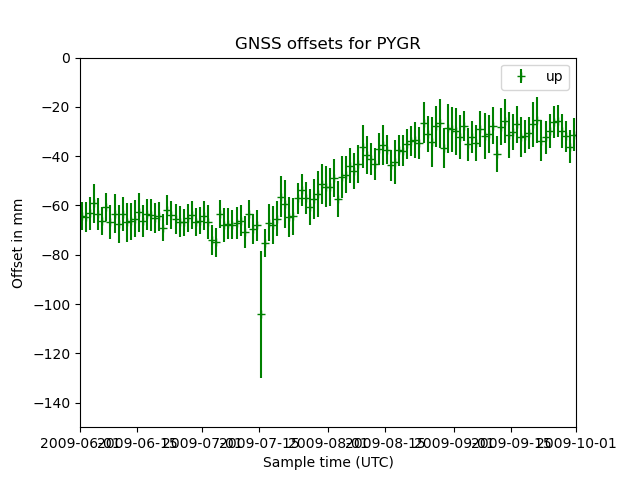

In [18]:
fig, ax = plt.subplots()
ax.errorbar(pygr_data["time"], pygr_data["up"],
            yerr=pygr_data["up_error"],
            marker="+", linestyle="None",
            label=component, color="green")
ax.set_xlim(datetime.datetime(2009, 6, 1), datetime.datetime(2009, 10, 1))
ax.set_ylim(-150, 0)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

Great, we can see that there is a large error for a particular point there.  For those who haven't guessed it yet, this is the day of the [Dusky Sound earthquake](https://www.geonet.org.nz/earthquake/story/3124785). The errors are largest here because the displacement is a) large and b) not instantaneous. There are components of co-seismic and post-seismic slip in this one data-point that effectively smear the motion. 

These daily GPS solutions are not *true* measurements, rather a model of the displacements based on data. To use these data to model slip on faults, or other phenomena models are often built on top of these daily solutions (models themselves).  If you don't understand the uncertainty in your data (whether those data are raw data, or modeled data) you won't understand the uncertainty in your final result...

One last thing for now, our tick labels on the x-axis are overlapping, obscuring them from view. Lets sort that out as well:

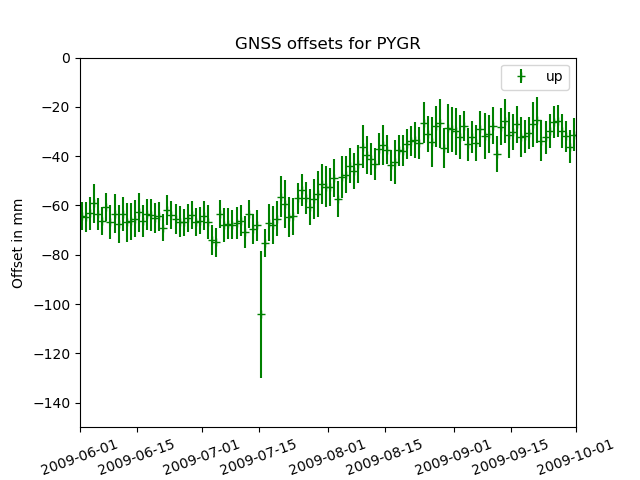

In [21]:
fig, ax = plt.subplots()
ax.errorbar(pygr_data["time"], pygr_data["up"],
            yerr=pygr_data["up_error"],
            marker="+", linestyle="None",
            label=component, color="green")
ax.set_xlim(datetime.datetime(2009, 6, 1), datetime.datetime(2009, 10, 1))
ax.set_ylim(-150, 0)
# Set the x-labels to be rotated so that they don't overlap.
plt.setp(ax.xaxis.get_majorticklabels(), rotation=20)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

**Exercise:** Make a plot of the GNSS time-series for a station of your choosing. 

Look on the [GeoNet station search](https://www.geonet.org.nz/data/network/sensor/search) and tick the
GNSS/GPS box to show the GNSS stations.  Try and find one that you think will have some interesting signals.
Hint, find somewhere near a large earthquake, or close the Hikurangi margin where slow-slip regularly occurs.

In [36]:
# Your plots here.

# NumPy: Numerical Python

We've seen with Matplotlib how importing code ("modules", or "packages", or "libraries") written by someone else, or more likely a huge team of people, enables us to focus on the science we're interested in while leaving much of the heavy-lifting to a module. This sort of philosopy underpins a lot of Python programming and we'll look into it a little further by using a really important package, [NumPy](https://numpy.org/).

<img alt="Numpy logo" align="right" style="width:30%" src="https://upload.wikimedia.org/wikipedia/commons/3/31/NumPy_logo_2020.svg">

NumPy is flipping excellent. NumPy is at the heart of almost all scientific Python applications. If you are
not using NumPy directly you are probably using something that uses NumPy.  If you google around on the
topic of Python, you will undoubtedly find people saying:

> Python is slow

and they are not wrong, Python itself isn't very fast (although if you are a good programmer and know how what you're doing you can can get Python to be *fast enough* for many applications), but one of the super-powers of Python
is its extensibility. NumPy extends Python with many fast and well-tested C, C++ and Fortran libraries, and
provides *the* way to handle arbitrarily large and dimensional arrays of data in Python.

> **NumPy** is fast

## Speed

Lets first show that speed, and some of the additional simplicity that NumPy brings.  We'll write a function that adds a number to every value in an array using a simple loop.

In [23]:
def add_to_array(array, number_to_add):
    """ Add one number to all values in an array. """
    for number in array:
        number += number_to_add
    return array

To test how long this takes and compare to NumPy, we will create an array (similar to a list)
of 1 million random numbers.  We will use NumPy's 
[random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html) 
function to make this array.  It is a standard convention to `import numpy as np`: you don't have to,
it is just people being lazy and conventional and trying to avoid typing `numpy` quite so many times.

To check what we have made we will look at the shape of the array. Every NumPy array has a `.shape` property,
which tells us the dimensions of the array (remember that a NumPy array is n-dimensional).  This shape is
returned as a `tuple` (hence the round brackets and comma).  We will make a 1x1000000 array. As it's a one-dimensional array, only the
length is given.

In [24]:
import numpy as np

array = np.random.randn(int(1e6))
print(array.shape)

(1000000,)


Great, we have an array!  Lets try using our function to add 2 to every value in the array.  We don't really care
about the outcome of this, but we will test how long it takes using the `timeit` magic.  This is a jupyter/ipython
inline decorator. The outcome of it is that it times how long our function takes an averages over many loops.

In [25]:
%timeit add_to_array(array, 2)

54.8 ms ± 621 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


On my computer I get something around 220 milli-seconds. 

Lets try the same with NumPy's add. We can just use the `+` symbol, or the `+=` for in-place
addition. (Note that `+=` is faster, but doesn't work with the `timeit` magic.)

In [26]:
%timeit array + 2

322 µs ± 2.91 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


On my computer I get something around 920 micro-seconds, or around 200 times faster.  Both times are quite fast,
but when you are doing an operation many times, NumPy gets the speed you need.

So, NumPy is fast for some things... We are not going to provide an exhaustive NumPy tutorial here, for that
look to the [canonical NumPy tutorial](https://numpy.org/doc/stable/user/quickstart.html). Instead, lets focus on
why you should (or might) care about NumPy by playing with some data.

## Reading in data: DFDP-2 temperatures

In late 2013 to early 2014, we (led by scientists from VUW, GNS Science, and the University of Otago) drilled an hole near the Alpine Fault.  Unfortunately we came up short of the Alpine Fault, but we got some pretty amazing data from the hole.  The temperatures we measured using a distributed fibre-optic sensing method were pretty unusual - that is, very hot! - and were
the topic of a [Nature paper](https://www.nature.com/articles/nature22355).  We provided
the temperature data as a supplement to the paper and have extracted a subset of the data to play with here.

_(If for some reason someone comes across these notebook and wants to use these data, get the raw data from the
paper and cite the paper!)_

NumPy provides a nice way to load data from a text-file:

In [27]:
temp_data = np.loadtxt(
    "data/Sutherland_etal_DFDP_temperatures.csv", delimiter=",",
    skiprows=1)
print(temp_data)

[[ 0.00000e+00  2.40000e-02  0.00000e+00  0.00000e+00  0.00000e+00
           nan]
 [ 1.00000e+00  2.60000e-02  0.00000e+00  0.00000e+00  1.00000e+00
   1.10590e+01]
 [ 2.00000e+00  3.00000e-02 -1.00000e-03  0.00000e+00  2.00000e+00
   1.05640e+01]
 ...
 [ 8.91000e+02  4.42910e+01 -8.14500e+01  2.40027e+02  8.16568e+02
           nan]
 [ 8.92000e+02  4.43390e+01 -8.16570e+01  2.40694e+02  8.17283e+02
           nan]
 [ 8.93000e+02  4.43820e+01 -8.18640e+01  2.41362e+02  8.17998e+02
           nan]]


Here we used the `delimiter` argument to tell NumPy that the file is comma separated (its a .csv file),
and the `skiprows` argument to skip the header. Lets check what that header is:

In [28]:
with open("data/Sutherland_etal_DFDP_temperatures.csv", "r") as f:
    # Open the file read-only in a context-manager
    print(f.readline())
    # Read one line (the zeroth) from the file and print it.

﻿Drilled depth (m),Tilt (Degrees),Distance E (m),Distance N (m),True Vertical Depth (m),Temperature (degrees C)



Now we know what is in each column. One thing to note in passing is the difference between "Drilled depth" (which is measured along the borehole) and "True Vertical Depth" (which takes into account the fact that the borehole was strongly deviated towards the Alpine Fault by the strong fabric of the rocks being drilled.

## Indexing and slicing NumPy arrays

We can access the parts of the array by index, or slice.  A slice is a range of indexes, and allows us to grab
chunks of an array.  Lets work out what our array looks like and extract some data from it:

In [29]:
print(temp_data.shape)

(894, 6)


This means that our array has 894 x 6 elements. At the moment our data are indexed by row first, then column,
so that if we get the zeroth index of our data it will be the first row:

In [30]:
temp_data[0]

array([0.   , 0.024, 0.   , 0.   , 0.   ,   nan])

If we want the temperature (column 5, starting from 0) from the 4th row we would have to do:

In [31]:
temp_data[4][5]

9.798

This is all well and good, but it will be easier for what we're doing below to be able to interpret the array in terms of columns first, then rows.  We can *transpose* our data to get it into the shape we want:

In [32]:
temp_data = temp_data.T
print(temp_data.shape)

(6, 894)


Now we can easily get all the temperatures by extracting the 5th column:

In [33]:
print(temp_data[5])

[    nan  11.059  10.564  10.121   9.798   9.679   9.61    9.603   9.614
   9.621   9.623   9.628   9.635   9.637   9.655   9.679   9.692   9.754
   9.874  10.034  10.14   10.197  10.261  10.327  10.409  10.472  10.543
  10.622  10.714  10.758  10.771  10.782  10.821  10.904  10.964  10.961
  10.987  11.019  11.068  11.092  11.131  11.202  11.227  11.25   11.311
  11.335  11.388  11.457  11.557  11.704  11.841  11.963  12.122  12.267
  12.406  12.563  12.716  12.865  12.974  13.107  13.297  13.535  13.822
  14.018  14.162  14.273  14.341  14.365  14.39   14.408  14.455  14.541
  14.722  15.16   15.821  16.252  16.633  17.019  17.338  17.664  17.983
  18.272  18.546  18.835  19.092  19.328  19.582  19.865  20.124  20.355
  20.601  20.841  21.076  21.325  21.575  21.796  22.037  22.277  22.491
  22.726  22.951  23.178  23.416  23.64   23.858  24.072  24.283  24.488
  24.707  24.918  25.136  25.357  25.554  25.751  25.941  26.136  26.346
  26.548  26.76   26.953  27.116  27.307  27.501  2

Aaagh! That looks horrible, so let's plot it instead. I have re-written this to have all the parts you need - like a script that you might run in the future!

First we'll plot it against _drilled depth_, which is in the zeroth column. The code below should seem fairly familiar because all we're doing is plotting one variable against another with Matplotlib as we

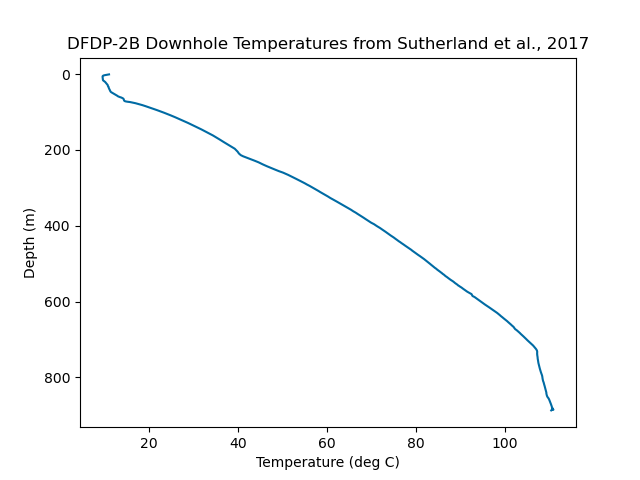

In [34]:
import numpy as np
import matplotlib.pyplot as plt

temp_data = np.loadtxt(
    "data/Sutherland_etal_DFDP_temperatures.csv", delimiter=",",
    skiprows=1)
temp_data = temp_data.T

fig, ax = plt.subplots()
ax.plot(temp_data[5], temp_data[0])
ax.set_xlabel("Temperature (deg C)")
ax.set_ylabel("Depth (m)")
ax.set_title("DFDP-2B Downhole Temperatures from Sutherland et al., 2017")
ax.invert_yaxis()  # Invert the y-axis so increasing depth is down
plt.show()

## Array maths: calculating temperature gradient

Sutherland et al. calculated temperature gradients in degrees per km.  This is simply division, and we can do this really
easily with NumPy using the simple formula:
\begin{equation}
    T\ gradient = \frac{change\ in\ T}{change\ in\ depth}
\end{equation}

So, we need the change in temperature and change in depth at every step. We can do this by subtracting a 1-sample
shifted version of our column of interest from the column, e.g.

In [36]:
temperature_change = temp_data[5][1:] - temp_data[5][0:-1]

This looks a bit funky, but all that we have done is sliced our array so that we get the fifth column (the temperatures)
(using the `[5]` index) and taken the elements of that column between the zeroth to n-1-th indexes away from
that data from the same column, but from the 1st to the n-th index. 

We will do the same for the depth:

In [37]:
depth_change = temp_data[0][1:] - temp_data[0][0:-1]

Lets plot our change in temperature to make sure we have something sensible.  We need to plot against depth, but our change in temperature
is an average over a depth range. We will plot against the mid-point of the depths that the change in temperature is calculated over, lets
make a new array that is that mid-point depth:

In [38]:
mid_point_depth = temp_data[0][0:-1] + depth_change / 2

All that we have done is add half the change in depth to the depth. We have to ignore the final depth sample because
we don't have a gradient that corresponds to this: there are no data beyond the end of the borehole, alas.

Now we can plot again. Again I have put together all that we had above so that this runs like a script.

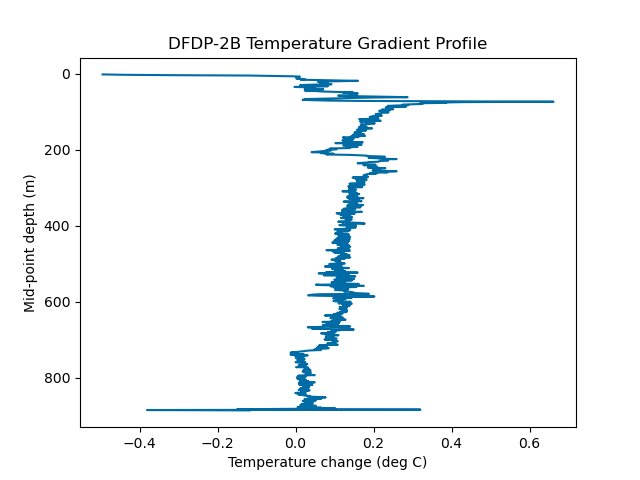

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Read in the data
temp_data = np.loadtxt(
    "data/Sutherland_etal_DFDP_temperatures.csv", delimiter=",",
    skiprows=1)
temp_data = temp_data.T

# Calculate gradients
temperature_change = temp_data[5][1:] - temp_data[5][0:-1]
depth_change = temp_data[0][1:] - temp_data[0][0:-1]
mid_point_depth = temp_data[0][0:-1] + depth_change / 2

# Plot the gradients
fig, ax = plt.subplots()
ax.plot(temperature_change, mid_point_depth)
ax.set_xlabel("Temperature change (deg C)")
ax.set_ylabel("Mid-point depth (m)")
ax.set_title("DFDP-2B Temperature Gradient Profile")
ax.invert_yaxis()  # Invert the y-axis so increasing depth is down
plt.show()

Now we have the change in temperature and the change in depth we can calculate the temperature gradient at each point as a simple
division.

To get the units into degrees per km we will divide our change in depth by 1000 to convert to km first.

In [40]:
depth_change /= 1000
temperature_gradient = temperature_change / depth_change

Again, lets plot the result at the mid-points (again, I have put this all into one cell):

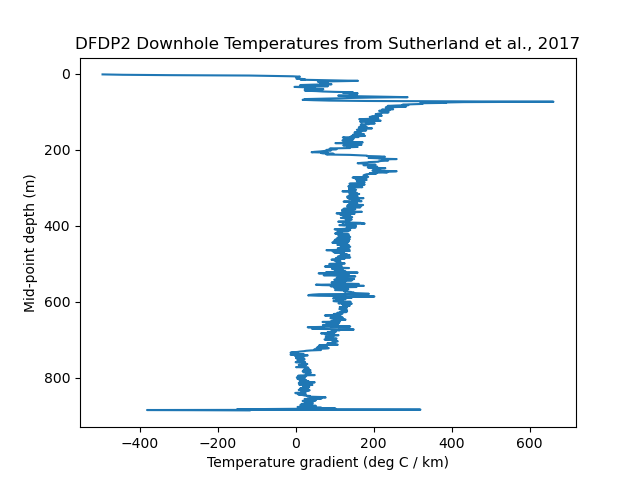

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Read in the data
temp_data = np.loadtxt(
    "data/Sutherland_etal_DFDP_temperatures.csv", delimiter=",",
    skiprows=1)
temp_data = temp_data.T

# Calculate gradients
temperature_change = temp_data[5][1:] - temp_data[5][0:-1]
depth_change = temp_data[0][1:] - temp_data[0][0:-1]
mid_point_depth = temp_data[0][0:-1] + depth_change / 2

# Calculate degC per km
depth_change /= 1000
temperature_gradient = temperature_change / depth_change

fig, ax = plt.subplots()
ax.plot(temperature_gradient, mid_point_depth)
ax.set_xlabel("Temperature gradient (deg C / km)")
ax.set_ylabel("Mid-point depth (m)")
ax.set_title("DFDP2 Downhole Temperatures from Sutherland et al., 2017")
ax.invert_yaxis()  # Invert the y-axis so increasing depth is down
plt.show()

A brief inspection shows that the last two plots look very similar, this is because the depth sampling is 1m.

**But wait!**  This isn't a true depth profile, this is just drilled depth...  We didn't drill a straight hole
(not deliberately, but these things happen when you are a few hundred meters down in highly-foliated schist...).

Let's have a look at what the hole looks like:

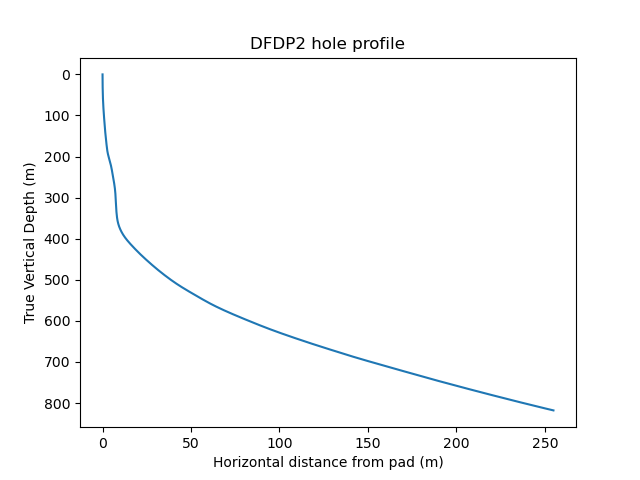

In [42]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcdefaults()  # Go back to a more professional-looking style...

# Read in the data
temp_data = np.loadtxt(
    "data/Sutherland_etal_DFDP_temperatures.csv", delimiter=",",
    skiprows=1)
temp_data = temp_data.T

horizontal_distance = np.sqrt(temp_data[2] ** 2 + temp_data[3] ** 2)
fig, ax = plt.subplots()
ax.plot(horizontal_distance, temp_data[4])
ax.set_xlabel("Horizontal distance from pad (m)")
ax.set_ylabel("True Vertical Depth (m)")
ax.set_title("DFDP2 hole profile")
ax.invert_yaxis()  # Invert the y-axis so increasing depth is down
plt.show()

**Exercise:** 
Plot the temperature gradient against true vertical depth.  You will need to recalculate the depth changes and the temperature gradient to do this.

Do your plots look like the plot in the [Sutherland et al. paper](https://www.nature.com/articles/nature22355)?

In [56]:
# Your answer here

## Saving your data

So you have dome some cool things to your data, and you want to save your work.  You should always save your
notebook or scripts, and they should be your *sacred* way of doing your analysis.  But it is also
good to actually write out the data that you have processed.  With NumPy there are a few ways that you
can do that.  One of the simplest ways is using the 
[savetxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savetxt.html) function:

In [57]:
np.savetxt("data/temperature_gradient.txt", temperature_gradient)

Lets check what is in that file by printing the first five lines:

In [45]:
with open("data/temperature_gradient.txt", "r") as f:
    for i in range(5):
        print(f.readline().rstrip())

nan
-4.949999999999992042e+02
-4.429999999999996021e+02
-3.230000000000003979e+02
-1.189999999999997726e+02


Looks correct.  Note that the `.rstrip` method on a string strips trailing white-space characters, in
this case it removes a new-line (`\n`) character.

## Summary

NumPy is at the heart of most scientific Python, but it can be unintuitive when thinking about many Earth science datasets. Having to remember which column and row things should be in can be a little frustrating. This is one of the things that Pandas can help us with and we will showcase this in the [pandas notebook](ESCI451_Module_2B.ipynb) next.